<a href="https://colab.research.google.com/github/elleneee/CS-6120-final-project---Fake-News-Detection/blob/main/Fake%20news%20detection%20using%20bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import and install packages

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

# Step 2: Load data

In [ ]:
import kagglehub
import os
import shutil

# Download latest version
# for dataset see: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

destination_path = "./news_detection"

os.makedirs(destination_path, exist_ok=True)

for file_name in os.listdir(path):
    shutil.move(os.path.join(path, file_name), destination_path)

fake_data = pd.read_csv(destination_path+"/News _dataset/Fake.csv")
real_data = pd.read_csv(destination_path+"/News _dataset/True.csv")

100%|██████████| 41.0M/41.0M [00:00<00:00, 85.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1


# Step 3: Data analysis

In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


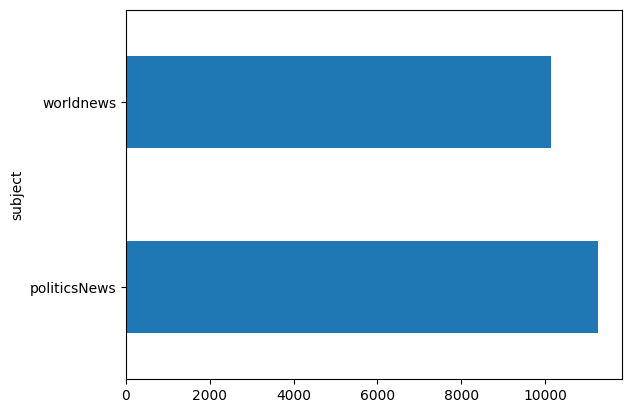

In [ ]:
# subject distribution of real news
real_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

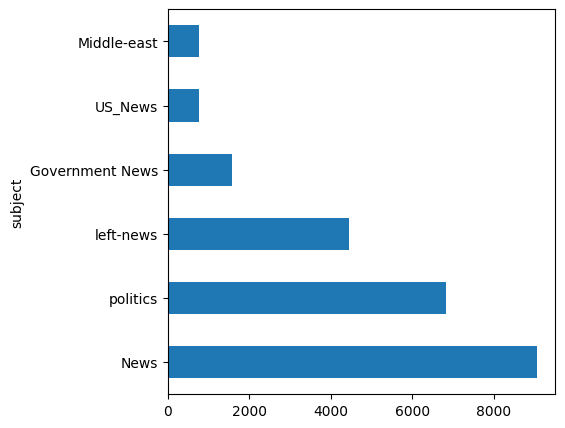

In [ ]:
# subject distribution of fake news
fake_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

## Wordcloud for real text data

In [ ]:
#　Download the image from url
# Import required library
import requests

# URL of the image
url = "https://user-images.githubusercontent.com/46570219/113926636-1630a300-97f5-11eb-8bf5-20723ebe27e0.png"

# Download the image and save it locally
response = requests.get(url)
if response.status_code == 200:
    with open("twitter.png", "wb") as f:
        f.write(response.content)
    print("Image downloaded and saved as 'twitter.png'")
else:
    print("Failed to download the image.")


wordcld_mask=np.array(Image.open("twitter.png"))
wordcld_text=" ".join(real_data["text"].tolist())

Image downloaded and saved as 'twitter.png'


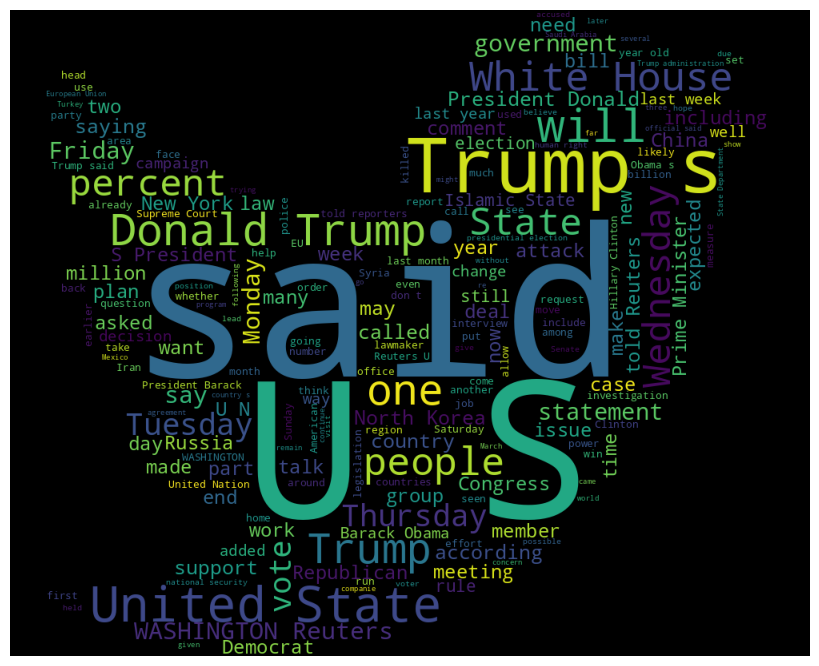

In [ ]:
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Wordcloud for fake text data

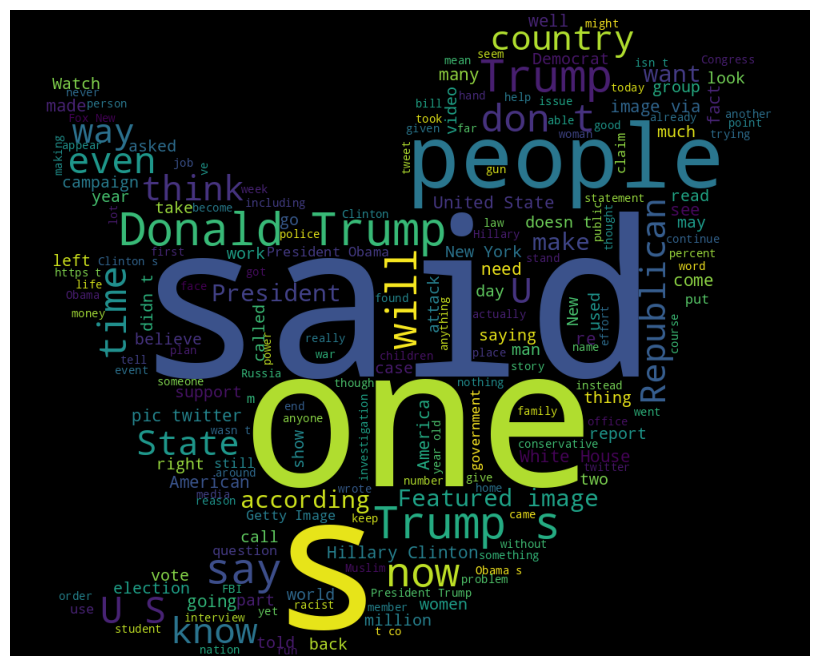

In [ ]:
fake_text=" ".join(fake_data["text"].tolist())
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(fake_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Step 4: Preprocess

In [ ]:
# add labels to news data
fake_data["label"]="fake"
real_data["label"]="real"

# concat real and fake news data
final_data= pd.concat([fake_data,real_data])

# reset index
final_data = final_data.sample(frac=1).reset_index(drop=True)

# drop columns with few contribution to the classification task
final_data.drop(["subject","date"], axis=1)

,title,text,label
0,Episode #120 – SUNDAY WIRE: ‘Crisis of Liberty...,Episode #120 of SUNDAY WIRE SHOW finally resum...,fake
1,Trump Fans Protest Starbucks And Twitter Laug...,A movement has apparently been afoot in many S...,fake
2,U.S. completes 'takedown' of Medicare fraud: o...,WASHINGTON (Reuters) - U.S. law enforcement of...,real
3,Trump’s Trying To Attend Muhammad Ali’s Musli...,"Donald Trump, the GOP candidate who has been c...",fake
4,WOW! STARBUCKS CEO JUST ACCUSED Whites Of Comm...,Thousands of Starbucks customers cut up their ...,fake
...,...,...,...
44893,WHY Ugly HATE And DIVISION In America Is Actua...,"This is Obama s legacy of hate and division, a...",fake
44894,How Kim Davis Got A Seat To Attend State Of T...,If there s one person in this entire nation wh...,fake
44895,TWO NEW POLLS Offer BAD NEWS For Democrats….Wh...,"Last week, the Washington Post reported that a...",fake
44896,PA Senator Issues An EPIC Challenge To Trump ...,"Recently, Donald Trump shocked even his critic...",fake


<Axes: xlabel='label', ylabel='count'>

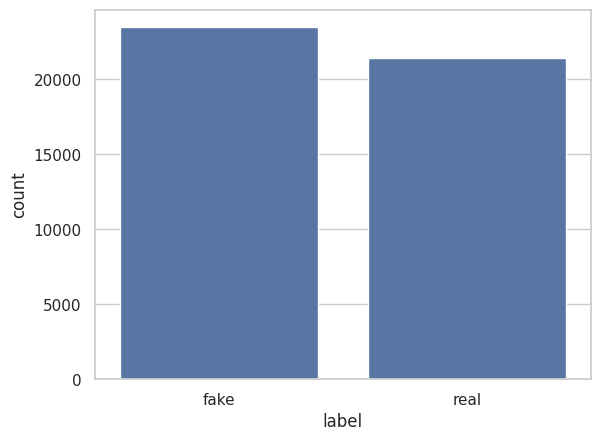

In [ ]:
# visualize the distribution of fake and real news data
sns.set_theme(style="whitegrid")
sns.countplot(x=final_data["label"])

In [ ]:
# combine text and title as a whole text column
final_data["text"]=final_data["title"]+final_data["text"]

# use only text and label column in the data
final_data=final_data[["text","label"]]

# map real and fake news label as 1 and 0
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

# take a look at final data
final_data.head(10)

<ipython-input-12-62c154a05a6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['label'] = final_data['label'].map({'real':1, 'fake':0})


,text,label
0,Episode #120 – SUNDAY WIRE: ‘Crisis of Liberty...,0
1,Trump Fans Protest Starbucks And Twitter Laug...,0
2,U.S. completes 'takedown' of Medicare fraud: o...,1
3,Trump’s Trying To Attend Muhammad Ali’s Musli...,0
4,WOW! STARBUCKS CEO JUST ACCUSED Whites Of Comm...,0
5,Lindsey Graham: Trump Should Be Treated With ...,0
6,BREAKING NEWS: Bernie Supporters Caught Plagia...,0
7,Soda taxes spread after votes in four U.S. cit...,1
8,CAUGHT ON CAMERA: MULTIPLE ATTACKS Against Oly...,0
9,"After Trump tweet, ethics office to U.S. emplo...",1


In [ ]:
# define the max length of token
# Tokenization max length
max_len=100

# Sample_size, maximum 20000
sample_size=1000

# sample the data to boost training
data_0 = final_data[final_data["label"] == 0].sample(n=sample_size, random_state=42)

data_1 = final_data[final_data["label"] == 1].sample(n=sample_size, random_state=42)

balanced_data = pd.concat([data_0, data_1]).reset_index(drop=True)

data_text = balanced_data["text"]
data_label = balanced_data["label"]

# split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1600,), (400,), (1600,), (400,))

# Step 5: Model training

In [ ]:
# get pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# tokenization function
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [ ]:
# tokenize training and testing data
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

## Create Bert model


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# bert layer
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    # get pooled output for classification
    def call(self, inputs):
        return self.bert(inputs)[1]

# define our own create model function
def create_model(bert_model, maxlen=100):
    # input for bert of shape (batch_size, maxlen)
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    # attention mask for bert model
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # get the pooled output for bert layer
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})

    # define our own layer for classification (fine-tune)
    # randomly dropout 50% of neurons while training to avoid overfit
    x = Dropout(0.5)(pooled_output)
    # transform and activate
    x = Dense(64, activation="tanh")(x)
    # dropout again
    x = Dropout(0.5)(x)
    # transform into probability from 0-1
    output = Dense(1, activation="sigmoid")(x)

    # return our model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(bert_model)

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 768)            │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         49,216 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric you want to monitor
    patience=3,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)
# use ReduceLROnPlateau for changing learning rate while training for quicker converge
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)

## Kfold

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from transformers import logging

logging.set_verbosity_error()

def k_fold_trainig(X_train_token, Y_train, learning_rates, epoch=20, batch_size=30):

  # initialize KFold of 5 fold
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  # store the training result for each fold
  fold_history = []
  val_accuracies = []
  val_losses = []
  best_lr = None
  best_loss = float('inf')

  # transform data into numpy array
  X_input_ids = np.array(X_train_token['input_ids'])
  X_attention_mask = np.array(X_train_token['attention_mask'])
  Y_train_np = Y_train.to_numpy()  # Convert Y_train to NumPy array

  for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")

    # iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_input_ids)):
        print(f"\nTraining on Fold {fold + 1}/{kf.n_splits}")

        # training data
        X_train = {
            'input_ids': X_input_ids[train_idx],
            'attention_mask': X_attention_mask[train_idx]
        }
        Y_train = Y_train_np[train_idx]

        # validation data
        X_val = {
            'input_ids': X_input_ids[val_idx],
            'attention_mask': X_attention_mask[val_idx]
        }
        Y_val = Y_train_np[val_idx]

        # create a new model for each fold
        bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        model = create_model(bert_model, maxlen=100)

        # compile the model before using
        optimizer = Adam(learning_rate=lr, epsilon=1e-08, decay=0.01,clipnorm=1.0)
        model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

        # train and record the history of training
        history = model.fit(
            x=X_train,
            y=Y_train,
            epochs=epoch,
            batch_size=batch_size,
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping, reduce_lr]
        )

        # acc and loss for current fold
        val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # append the history into the result
        fold_history.append(history.history)

    # Kfold average acc and loss
    avg_val_loss = np.mean(val_losses)
    avg_val_acc = np.mean(val_accuracies)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_lr = lr

    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Validation Accuracy: {avg_val_acc:.4f}")

  print(f"Best Learning Rate: {best_lr}")
  print("K-Fold Training Complete")

# start K-Fold
learning_rates = [1e-05, 1e-04, 1e-03]
k_fold_trainig(X_train_token, Y_train, learning_rates , epoch=20, batch_size=64)


Training with Learning Rate: 1e-05

Training on Fold 1/5
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 736ms/step - accuracy: 0.5116 - loss: 0.8020 - val_accuracy: 0.5281 - val_loss: 0.7056 - learning_rate: 1.0000e-05
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - accuracy: 0.4943 - loss: 0.8357 - val_accuracy: 0.4750 - val_loss: 0.7009 - learning_rate: 1.0000e-05
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 443ms/step - accuracy: 0.5047 - loss: 0.8390 - val_accuracy: 0.4875 - val_loss: 0.6983 - learning_rate: 1.0000e-05
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 493ms/step - accuracy: 0.4835 - loss: 0.8560 - val_accuracy: 0.4625 - val_loss: 0.6970 - learning_rate: 1.0000e-05
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.4908 - loss: 0.8234 - val_accuracy: 0.4875 - val_loss: 0.6958 - learning_rate: 1.0000e-05
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step - accuracy: 0.5140 - loss: 0.7957 - val_accuracy: 0.4844 - val_loss: 0.6948 - learning_rate: 1.0000e-05
E

## Original version

In [ ]:
# optimizer, learning rate and other hyperparameters
lr = 1e-04
optimizer = Adam(learning_rate=lr, epsilon=1e-08, decay=0.01,clipnorm=1.0)

# compile our model before using it
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# train and record history of training
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=20,
    batch_size=30,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 587ms/step - accuracy: 0.6600 - loss: 0.6314 - val_accuracy: 0.6950 - val_loss: 0.6212
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.6597 - loss: 0.6320 - val_accuracy: 0.6800 - val_loss: 0.6151
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.6647 - loss: 0.6209 - val_accuracy: 0.6925 - val_loss: 0.6150
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.6519 - loss: 0.6440 - val_accuracy: 0.6950 - val_loss: 0.6153
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.6609 - loss: 0.6300 - val_accuracy: 0.7000 - val_loss: 0.6182
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.6701 - loss: 0.6325 - val_accuracy: 0.6925 - val_loss: 0.6156
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.6708 - loss: 0.6262 - val_accuracy: 0.6800 - val_loss: 0.6146
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.6685 - loss: 0.6371 - val_accuracy: 0.680

In [ ]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 796ms/step


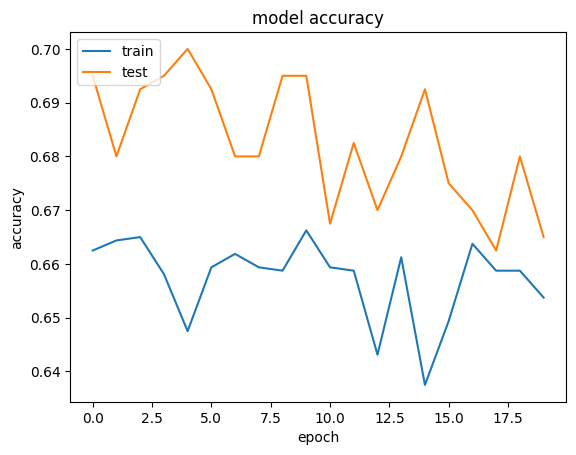

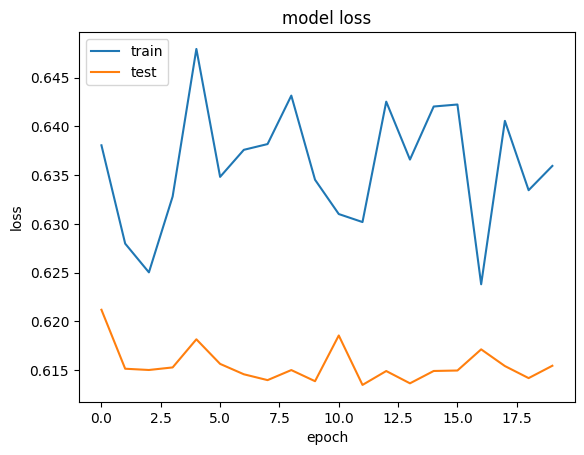

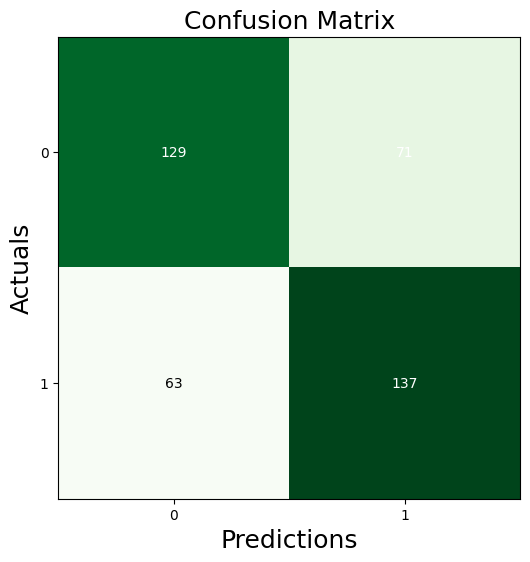

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       200
           1       0.66      0.69      0.67       200

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.66       400
weighted avg       0.67      0.67      0.66       400



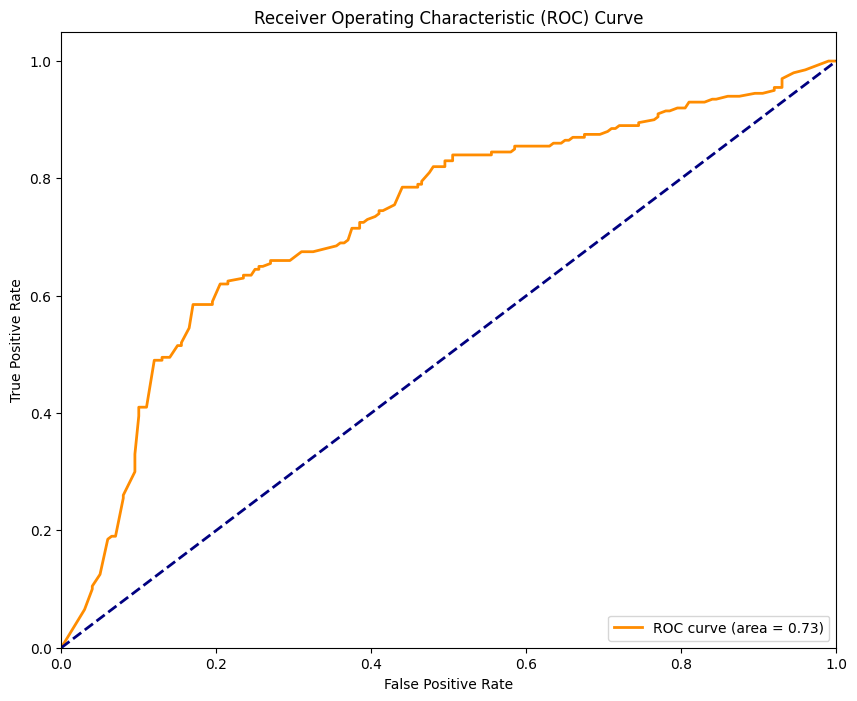

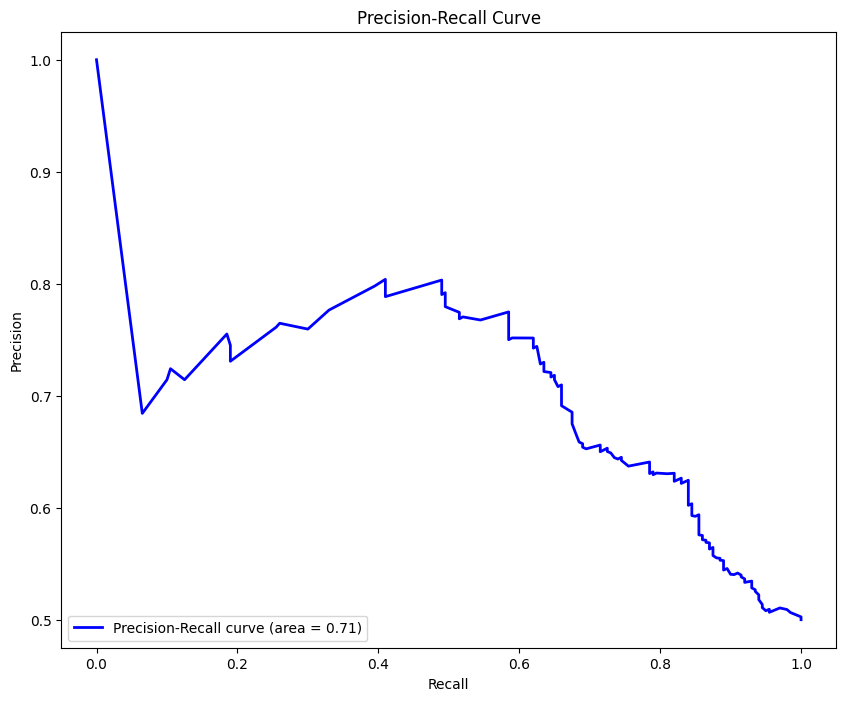

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot(history,y_pred):
  # summarize history for accuracy
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  conf_matrix = confusion_matrix(Y_test,y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

  print(classification_report(Y_test,y_pred))


  fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)  # Removed indexing on y_pred_prob
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(10,8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

  precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_proba)
  pr_auc = auc(recall, precision)

  plt.figure(figsize=(10,8))
  plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower left")
  plt.show()


plot(history.history, y_pred)